## Things do not understand

1. sequential API vs functional API
2. Siamese Neural Network
3. convolution neural network
4. Memory growth of GPU 
5. virtual environment
6. Scaling
7. data.cache()
8. train_data.prefetch(8)
9. redundant naming
10. create a trianing model

## New things

1. checking my GPU
2. moving files
3. cv2
4. each python version works with TF version
5. using tf.data.Dataset
6. zip and *
7. tf.data.Dataset.from_tensor_slices

# 1. Setup

## 1.1 Install Dependencies

In [1]:
%pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


## 1.2 import dependencies

Standerd dependancies

In [2]:
# opencv will give us image process capabilities, and we needs it for testing
import cv2
# it abstact the OS from our python code! makes it a whole heap, and easier to work with different directories and different file paths
import os
# ganerate random data
import random
# great when working with arrays
import numpy as np
# visualization
from matplotlib import pyplot as plt
# nameing images
import uuid

### Transorflow Ddpendencies

there is a sequintial API, and functional API. fancional API, usefull for hardcore deep learning models


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall


Model: Model(inputs=[inputimage, verificationimage], outputs=[0,1])

Layer: high level class, allows to define a cusom layer, class L1Dist(Layer)

Conv2v: allow convolution, convolutional nural newtwork

Dense: give us fully connected layer

MaxPooling: shrinks the information 

Input: Input(shape=)

flatten: flatten the data into a single dimension layer, allows to pass the convolutional neural network data to dense layer

## 1.3 Set GPU Growth

limits how much vram tensorflow can use, don't let TF to go crazy

In [4]:
# avoind OOM errors by setting GPU Memory Consumption Growth
# giting all available GPUs on our machien
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
len(gpus)

1

## 1.4 Create folder Structures

Anchor: Unknown Input

Positive: What should match

Negative: What should not match

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchoer')

In [7]:
# Mke the directories, just run them first time
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect positive and anchor data

## 2.1 Untar the dataset, Collect Negative data

In [8]:
# uncompress the database, just the first time
# !tar -xf lfw.tgz

In [9]:
# move dataset to the negative directory, just the first time

# for dir in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw', dir)):
#     EX_PATH = os.path.join('lfw', dir, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor data

That will be done using the openCV to access the camera 

In [10]:
# import uuid, universally unique identity identifier, to generate unique image names
import uuid

In [11]:
# # establish connection with webcam, !! just the first time
# #0 for your primary camera and 1 for your secondary camera
# cap = cv2.VideoCapture(0)
# # loop on every frame in our webcam
# print(cap.isOpened())
# while cap.isOpened():
#     # unpack the result
#     # ret: returned value!
#     # frame: actual frame, the actual image
#     ret, frame = cap.read()

#     # 2. Cut down frame to 250x250px
#     frame = frame[120:120+250, 200:200+250, :]
    
#     # 3. Collect anchor and positive
#     if cv2.waitKey(1) & 0xFF == ord('p'):
#         # Create image name
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # write out image
#         cv2.imwrite(imgname, frame)

#     if cv2.waitKey(1) & 0xFF == ord('a'):
#         # Create image name
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # write out image
#         cv2.imwrite(imgname, frame)
        
#     # to see what we doing, it shows the image back to the screen
#     # showing the feed from the webcam on the screen or inside cv2 frame
#     cv2.imshow('Image Collection', frame)

#     # Breaking gracefully
#     # waitKey(1): wait 1ms
#     # 0xFF == ord('q'): checking what key is being pressed,
#     # unpacking what is being pressed from our keyboard
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # release the webcam
# cap.release()
# # close the image show frame
# cv2.destroyAllWindows()

### Explination of collecting the positive and anchor images

In [12]:
# frame.shape 

In [13]:
# frame[x, y, channels]
# plt.imshow(frame[120:120+250, 200:200+250, :])

In [14]:
# frame before cut, the color looks diffrent because openCV have a different channel order
# plt.imshow(frame)

## 2.3 Data Augmentation

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img,max_delta=0.002, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100,seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [16]:
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path = os.path.join(ANC_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img)

#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1())),image.numpy())

In [17]:
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img)

#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1())),image.numpy())

### Explination of 2.3

In [19]:
# img_path = os.path.join(ANC_PATH,'4fbf3bfb-3bb4-11ed-ab95-7c8ae18b9df3.jpg')
# img = cv2.imread(img_path)
# augmented_images = data_aug(img)

# for image in augmented_images:
#     cv2.imwrite(os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1())),image.numpy())

# 3. Load and Preprocessing Images

## 3.1 Get image directories

In [20]:

# using a generator te be able to loop through specific directory
# creates a set or pipeline for files in this directory
# it loads the image path not the image itself
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(3000)

### Explination of 3.1

In [21]:
ANC_PATH + '\*.jpg'

'data\\anchoer\\*.jpg'

In [22]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchoer\\7dc9e394-471e-11ed-b732-7c8ae18b9df3.jpg'

### How we gonna train:

1. take a batch
2. calculate error/lost
3. calculate the gradients
4. update wights by apply the uprated gradients

this data pipeline or as_numpy_iterator allows us to this

## 3.2 PreProcessing - Scale and Resize

1. loads our images from directory
2. resize it
3. perform some scaling

Converting all images value from (255-0) to (1-0), to optimize performance of neural network for get the gradient descent

**this our goal:** dataset_generator.map(preprocessing_function)

In [23]:
def preprocess(file_path):

    # Read in image, as a bytes-like object, from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image/
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps
    # 1. resizing the image to be 100x100
    img = tf.image.resize(img,(100,100))
    # 2. Scale image to be between 0 and 1
    img /= 255.0
    return img

### Explination of 3.2

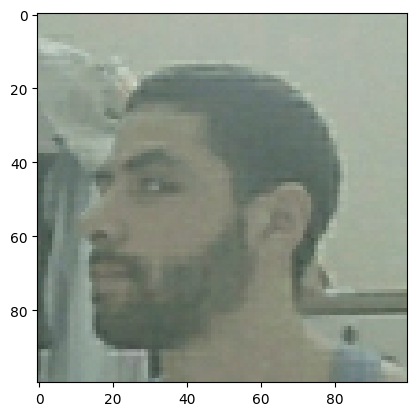

In [22]:

img = preprocess('data\\anchoer\\88a22e88-471e-11ed-a462-7c8ae18b9df3.jpg')
plt.imshow(img)

In [23]:
img.numpy().max()

0.84068626

## 3.3 Create Labelled Dataset

we gonna pass anchor with positive or negative image and get 1's or 0's

(anchor, positive) => 1,1,1,1,1

(anchor, negative) => 0,0,0,0,0

In [24]:
# zip to iterate the three of them at the same time 
positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data =  positive.concatenate(negative)

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

### Explination of 3.3 Collecte labelled dataset

In [26]:
tf.ones(len(anchor))

<tf.Tensor: shape=(3000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [27]:
class_labels = tf.data.Dataset.from_tensor_slices([1,2,3,4])
iterator_labels = class_labels.as_numpy_iterator()

In [28]:
iterator_labels.next()

1

In [29]:
# now we have a dataset with (anchor path, +/- path, label)
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [30]:
samples = data.as_numpy_iterator()

In [31]:
example = samples.next()

In [32]:
# Apply preprocessing function
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.65      , 0.7205882 , 0.66568625],
         [0.6507353 , 0.72132355, 0.6664216 ],
         [0.6492647 , 0.7139706 , 0.66789216],
         ...,
         [0.6428922 , 0.689951  , 0.63504905],
         [0.639951  , 0.6870098 , 0.63210785],
         [0.6333333 , 0.68039215, 0.6254902 ]],
 
        [[0.6546569 , 0.7134804 , 0.6627451 ],
         [0.65318626, 0.7139706 , 0.6629902 ],
         [0.65833336, 0.7147059 , 0.6637255 ],
         ...,
         [0.6431373 , 0.68921566, 0.6343137 ],
         [0.6431373 , 0.68921566, 0.6343137 ],
         [0.6362745 , 0.68235296, 0.627451  ]],
 
        [[0.6735294 , 0.7147059 , 0.6764706 ],
         [0.6666667 , 0.7137255 , 0.6666667 ],
         [0.66568625, 0.7147059 , 0.6666667 ],
         ...,
         [0.6431373 , 0.6862745 , 0.6313726 ],
         [0.6392157 , 0.68235296, 0.627451  ],
         [0.64215684, 0.6852941 , 0.63039213]],
 
        ...,
 
        [[0.4       , 0.44313726

In [33]:
# we getting three things as a result, a
len(res)

3

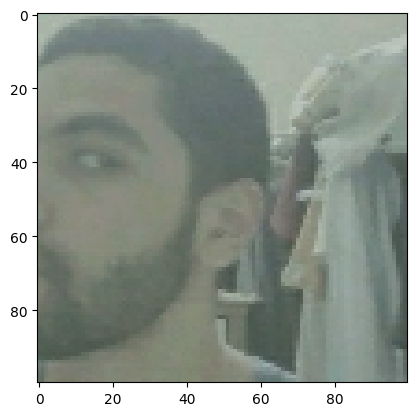

In [35]:
plt.imshow(res[0])

## 3.4 Build Train and Test Partition

In [26]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [27]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [28]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Explination of 3.4

In [37]:
samples = data.as_numpy_iterator()
samples 

In [38]:
example = samples.next()
example

(array([[[0.7058824 , 0.7490196 , 0.69411767],
         [0.7058824 , 0.7480392 , 0.6960784 ],
         [0.7026961 , 0.74191177, 0.6987745 ],
         ...,
         [0.67034316, 0.7134804 , 0.6477941 ],
         [0.6666667 , 0.70980394, 0.65294117],
         [0.6754902 , 0.70686275, 0.65588236]],
 
        [[0.69509804, 0.7382353 , 0.68333334],
         [0.6911765 , 0.73333335, 0.6813725 ],
         [0.70392156, 0.74313724, 0.7       ],
         ...,
         [0.6666667 , 0.7088235 , 0.65686274],
         [0.66838235, 0.7105392 , 0.65857846],
         [0.6666667 , 0.7058824 , 0.6627451 ]],
 
        [[0.6875    , 0.73063725, 0.6757353 ],
         [0.6872549 , 0.7294118 , 0.67745095],
         [0.6911765 , 0.73039216, 0.6872549 ],
         ...,
         [0.66593134, 0.7051471 , 0.6620098 ],
         [0.6644608 , 0.70367646, 0.6605392 ],
         [0.65392154, 0.6990196 , 0.65294117]],
 
        ...,
 
        [[0.3973039 , 0.45514706, 0.44632354],
         [0.3647059 , 0.4137255 , 0.38725

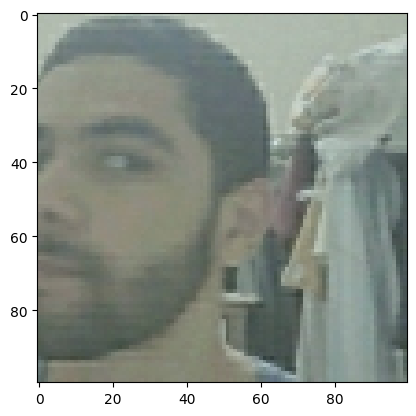

In [39]:
plt.imshow(example[0])

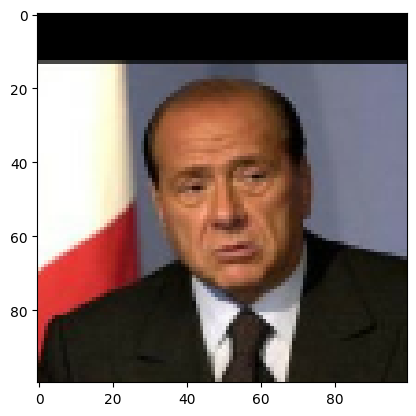

In [40]:
plt.imshow(example[1])

In [41]:
example[2]

0.0

In [44]:
# now rather than having one image per value we have 16, no. batch
train_sample = train_data.as_numpy_iterator()
train_sample = train_sample.next()
len(train_sample[0])

16

# 4. Model Engineering, Build our model

## 4.1. Build Embedding Layer

### Our core block for building the neural network:

1. Conv2D(no. flitters, filleter size, strokes=1, activation)

2. MaxPooling2D(no. flitters, filleter size, strokes=1, padding),
   * condensing down the amount of data,
   * padding is the same in order to replicate the output shape
  
make_embedding: will translate the input to a feature vector

In [29]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First Block 
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding_model = make_embedding()
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

### Explanation of make_embedding()

In [46]:
inp = Input(shape=(105, 105, 3), name='input_image')
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [48]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [49]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [50]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [51]:
print(c4)
print(str(6*6*256))
f1

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_7/Relu:0', description="created by layer 'conv2d_7'")
9216


<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_1')>

In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod

In [53]:
# we are in business guys
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2. Build Distance layer

sometimes they, !, pass three rivers/streams, anchor and validation and validation + anchor

In [30]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # the inheritance of Layer init
    def __init__(self, **kwargs):
        super().__init__()
    
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [31]:
l1 = L1Dist()
l1

## 4.3 Make Siamese Model

1. Handle input, two streams, anchor and validation
2. pass the inputs to **make_embedding**: now we have two featured vectors
3. pass the vectors to **L1Dist**: now we have a one vector represent the distance between two images
4. pass the distance vector to **classification layer** uses sigmoid activation function:  it uses Dense to create a fully connected layer, it will tell either the images/vectors are smiler or not based on the distance victor form step 3

In [32]:
def make_siamese_model():

    # 1. Handling Inputs:
    # Anchor image input
    input_img = Input(name='input_img', shape=(100,100,3))
    # Validation image
    validation_img = Input(name='validation_img', shape=(100,100,3))

    # 2+3. Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding_model(input_img),embedding_model(validation_img))
    
    # 4. Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    # combine all together
    return Model(inputs=[input_img, validation_img], outputs= classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

### Explanation of make_siamese_model

In [33]:
input_img = Input(name='input_img', shape=(100,100,3))
validation_img = Input(name='validation_img', shape=(100,100,3))

In [34]:
inp_embedded = embedding_model(input_img)
val_embedded = embedding_model(validation_img)

In [35]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedded,val_embedded)

In [36]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [37]:
siamese_mod = Model(inputs=[input_img, validation_img], outputs= classifier, name='SiameseNetwork')
siamese_mod.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

the whole perpouse of NN is to minimze the loss, cuz that means that it perform better for this function

Optimizer: is what perform the backpropagation 

In [38]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [39]:
# set learing rate = 0.0001
opt = tf.keras.optimizers.Adam(1e-4) 

## 5.2 Establish Checkpoints

Works as a placeholder where we could to get back and restart form

In [40]:
checkpoints_dir = "./training_checkpoints"
checkpoints_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

# to reload the checkpoint use:
# model.load('path_to_checkpoint')

## 5.3 Build Train Step Function

This define what happens when we train on a single batch

The basic steps for training on one batch:
1. Make a prediction
2. Calculate loss
3. Derive gradients
4. Calculate new weights and apply

In [41]:
@tf.function
# it compiles an entire neural network into a graph and allows us to
# trian it in efficient manner
# so we compiles what is going to happend under this function
def train_step(batch):

    # to perform the differentiation -> allows to perform Backpropegation -> so we get the gradients for NN
    # look at everything happend in the nn and
    with tf.GradientTape() as tape:
        # get anchor and postive/negative image
        X = batch[:2]
        # get label
        y = batch[2]

        # forword pass
        # yhat is y predicted
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grads = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated wieghts and apply to siamese model
    opt.apply_gradients(zip(grads, siamese_model.trainable_variables))
    return loss

Drowback with this method:

you have to define all progress bars and loss matrices being output

Solutoin: wrap them inside a module

### Explination of 5.2 build training function

In [42]:
test_batch = train_data.as_numpy_iterator()
test_batch

In [43]:
batch_1 = test_batch.next()
batch_1

(array([[[[0.8117647 , 0.81960785, 0.76862746],
          [0.8147059 , 0.8215686 , 0.78137255],
          [0.8088235 , 0.8127451 , 0.7872549 ],
          ...,
          [0.77254903, 0.78431374, 0.7411765 ],
          [0.76740193, 0.77916664, 0.74191177],
          [0.7627451 , 0.7745098 , 0.7392157 ]],
 
         [[0.81078434, 0.8186275 , 0.76960784],
          [0.80784315, 0.8147059 , 0.7745098 ],
          [0.81078434, 0.8147059 , 0.7877451 ],
          ...,
          [0.76936275, 0.7823529 , 0.72990197],
          [0.7654412 , 0.7762255 , 0.73259807],
          [0.7745098 , 0.7852941 , 0.7480392 ]],
 
         [[0.8068628 , 0.8147059 , 0.77156866],
          [0.81078434, 0.8183824 , 0.7759804 ],
          [0.8144608 , 0.8213235 , 0.78112745],
          ...,
          [0.7647059 , 0.77254903, 0.71862745],
          [0.76691175, 0.7747549 , 0.7296569 ],
          [0.777451  , 0.7852941 , 0.74215686]],
 
         ...,
 
         [[0.4014706 , 0.43970588, 0.50539213],
          [0.38357

In [44]:
# think of this as a features
x = batch_1[:2]
len(x)

2

In [45]:
# no. of components (anchor,positive/negative), batch size, shape (100x100x3)
np.array(x).shape

(2, 16, 100, 100, 3)

In [46]:
# just label
y = batch_1[2]
y

array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

## 5.4 Build Training Loop

apply train step on every epoch, entire data set oof epoches 

In [47]:
def trian(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        # print what epoch we up to
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        # show the prograce bar, if we rape this in a model we would not do it explicitly
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        # Loop through each batch
        # idx: counter, batch: actual batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoints_prefix)

## 5.5 Kickoff Trianing

In [48]:
EPOCHS = 50

In [49]:
trian(train_data,EPOCHS)
# stoped it as soon it got 100 r and p


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 149s 544ms/step
0.082497105 0.9340029 0.998977

 Epoch 2/50
263/263 [==============================] - 135s 512ms/step
0.029147658 0.9928161 0.9980742

 Epoch 3/50
 17/263 [>.............................] - ETA: 2:03

KeyboardInterrupt: 

We need something called  eager execution to print the loss

# 6. Evaluate Model

we goona use the precision and recall matrics

## 6.1 Import metrics calculations

In [77]:
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Get Prediction (y_hat)

In [50]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [51]:
# Make predictions, using my_model.predict
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.4767474e-06],
       [1.5712299e-06],
       [9.9999595e-01],
       [5.2926725e-07],
       [9.9999988e-01],
       [9.9768519e-01],
       [6.3335119e-06],
       [9.9999619e-01],
       [2.5129168e-06],
       [9.9807715e-01],
       [1.9552195e-05],
       [9.9999988e-01],
       [4.2012442e-04],
       [6.6003844e-04],
       [9.1879165e-01],
       [1.2496976e-05]], dtype=float32)

In [52]:
# Post Processing the results, the threshold is 0.5
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]

In [53]:
y_true

array([0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metics 

In [54]:
# Creating a metric object
m = Precision()

# Calculate the Recall value
m.update_state(y_true,y_hat)

# Return the result
m.result().numpy()

1.0

In [55]:
# Creating a metric object
m = Recall()

# Calculate the Recall value
m.update_state(y_true,y_hat)

# Return the result
m.result().numpy()

1.0

In [56]:
# get the evaluation of the entire dataset

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true,yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1.0 0.9967983


## 6.4 Viz Results

1.0


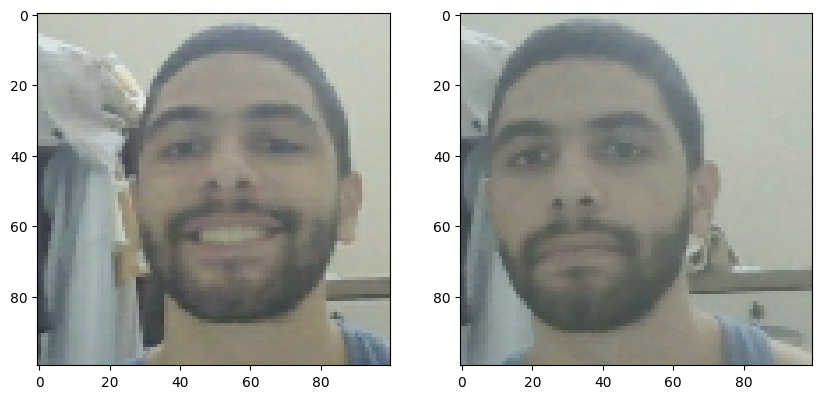

In [57]:
i=3
print(y_true[i])

# Set plot size
plt.figure(figsize=(10,8))

# subplot: allow to grid the plot, subplot(rows, columns,index)
# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[i])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[i])

# Render cleanly
plt.show()

# 7. Save Model

In [58]:
# save wights, this will save the weights and optimizer state, save_wights() just saves wights
siamese_model.save('siamese_modelv2.h5')

In [59]:
# Reload model
model = tf.keras.models.load_model('siamese_modelv2.h5',
custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [60]:
# Using the reloaded model, Makeing predictions
model.predict([test_input, test_val])

array([[1.0000000e+00],
       [7.9057263e-06],
       [3.0526303e-04],
       [9.9995410e-01],
       [1.8709452e-06],
       [3.6337601e-06],
       [8.9679259e-01],
       [9.9994087e-01]], dtype=float32)

In [61]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

I have in last two layers in model summary sare different: mine is l1_dist_3 and his is l1_dist_6, and mine is dense_2 and his is dense_3

# 8. Real time test

![the process](./verification.png)

## 8.1 Verification function

we gonna do the verification of the input image over 50 samples, the no. of images in verification_images

In [62]:
#  frame: what we pass form the cam to the model, the blue line
# deteciton_threshold: Metric above which a prediction considered positive. threshold of each image, if the image is positive or negative
#  verification_threshold: Proportion  of Positive predictions / Total positive samples (50 images). Threshold of all images predictions. 
def verify(model, deteciton_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_data','input_image.jpg'),)
        verification_img = preprocess(os.path.join('application_data','verification_images',image))

        # Make predictions
        result = model.predict(list(np.expand_dims([input_img,verification_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results)> deteciton_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold
    return results, verified

## 8.2 OpenCV real time verification

In [63]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    # frame = frame[120:120+250,200+250,:]
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('verification', frame)

    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save image
        cv2.imwrite(os.path.join('application_data','input_data','input_image.jpg'), frame)
        results, verified = verify(model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

True
True
True
True
True


In [64]:
np.sum(np.squeeze(results)>0.5)

36

In [1]:
30/50

0.6